In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [10]:
df = pd.read_csv('GSPC.csv')

In [11]:
df = df[['Date', 'Close']]

df

,Date,Close
0,2000-01-03,1455.219971
1,2000-01-04,1399.420044
2,2000-01-05,1402.109985
3,2000-01-06,1403.449951
4,2000-01-07,1441.469971
...,...,...
5616,2022-04-28,4287.500000
5617,2022-04-29,4131.930176
5618,2022-05-02,4155.379883
5619,2022-05-03,4175.479980


In [12]:
df['Date']

0       2000-01-03
1       2000-01-04
2       2000-01-05
3       2000-01-06
4       2000-01-07
           ...    
5616    2022-04-28
5617    2022-04-29
5618    2022-05-02
5619    2022-05-03
5620    2022-05-04
Name: Date, Length: 5621, dtype: object

In [13]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [14]:
df

,Date,Close
0,2000-01-03,1455.219971
1,2000-01-04,1399.420044
2,2000-01-05,1402.109985
3,2000-01-06,1403.449951
4,2000-01-07,1441.469971
...,...,...
5616,2022-04-28,4287.500000
5617,2022-04-29,4131.930176
5618,2022-05-02,4155.379883
5619,2022-05-03,4175.479980


In [15]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      2000-01-03
1      2000-01-04
2      2000-01-05
3      2000-01-06
4      2000-01-07
          ...    
5616   2022-04-28
5617   2022-04-29
5618   2022-05-02
5619   2022-05-03
5620   2022-05-04
Name: Date, Length: 5621, dtype: datetime64[ns]

In [16]:
df.index = df.pop('Date')
df

,Close
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971
...,...
2022-04-28,4287.500000
2022-04-29,4131.930176
2022-05-02,4155.379883


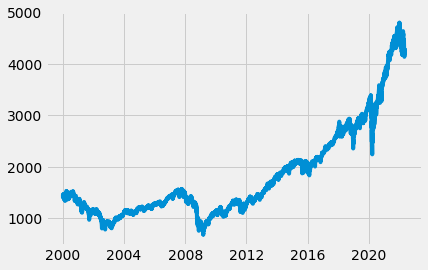

In [17]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [18]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2021-03-25', 
                                '2022-03-23', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,3940.590088,3910.520020,3889.139893,3909.520020
1,2021-03-26,3910.520020,3889.139893,3909.520020,3974.540039
2,2021-03-29,3889.139893,3909.520020,3974.540039,3971.090088
3,2021-03-30,3909.520020,3974.540039,3971.090088,3958.550049
4,2021-03-31,3974.540039,3971.090088,3958.550049,3972.889893
...,...,...,...,...,...
247,2022-03-17,4173.109863,4262.450195,4357.859863,4411.669922
248,2022-03-18,4262.450195,4357.859863,4411.669922,4463.120117
249,2022-03-21,4357.859863,4411.669922,4463.120117,4461.180176
250,2022-03-22,4411.669922,4463.120117,4461.180176,4511.609863


In [19]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((252,), (252, 3, 1), (252,))

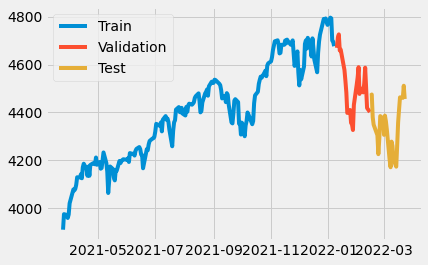

In [20]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [23]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

Epoch 1/20
7/7 [==============================] - 3s 111ms/step - loss: 19410798.0000 - mean_absolute_error: 4400.9053 - val_loss: 20388204.0000 - val_mean_absolute_error: 4513.9478
Epoch 2/20
7/7 [==============================] - 0s 14ms/step - loss: 19410570.0000 - mean_absolute_error: 4400.8789 - val_loss: 20387882.0000 - val_mean_absolute_error: 4513.9136
Epoch 3/20
7/7 [==============================] - 0s 12ms/step - loss: 19409470.0000 - mean_absolute_error: 4400.7539 - val_loss: 20384994.0000 - val_mean_absolute_error: 4513.5928
Epoch 4/20
7/7 [==============================] - 0s 9ms/step - loss: 19407404.0000 - mean_absolute_error: 4400.5186 - val_loss: 20384610.0000 - val_mean_absolute_error: 4513.5503
Epoch 5/20
7/7 [==============================] - 0s 9ms/step - loss: 19406990.0000 - mean_absolute_error: 4400.4722 - val_loss: 20384224.0000 - val_mean_absolute_error: 4513.5068
Epoch 6/20
7/7 [==============================] - 0s 10ms/step - loss: 19406522.0000 - mean_abso

In [25]:
train_predictions = model.predict(X_train).flatten()

In [27]:
train_predictions.shape

(603,)

In [28]:
X_train.shape

(201, 3, 1)